In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from matplotlib import gridspec

import sys
sys.path.append("../")
from fit2gauss import fit2gauss

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm
# Rebuild the matplotlib font cache
fm._rebuild()

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

clrs = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#93003a']

plt.rcParams['text.usetex'] = True

In [3]:
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h369_5min_gaussian_test_nolimiter.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h369_gaussian_nolimiter_si_iv_nei.sav',verbose=False,python_dict=False)
#tube = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h369_5min_gaussian_test.sav',verbose=False,python_dict=False)
#frac = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h369_gaussian_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [4]:
t_n = tube.tarr.shape[0] - 1 # len of tube in time (in steps of 0.2s)
line = 1402.77

In [5]:
# set inital values
line_cgs = 1402.77*1e-8 # cm.
mass = 28.0*1.66054e-27 # g
#kb = 1.3807e-23
kb = 1.3807*1e-16 # cm^2 g /s^2 /K
#c = 300 # Mm/s
c = 3.*1e10 # cm /s
h = 6.62607e-27 # g cm^2 /s
flux=1.0e3 #? why this val?

ll = np.arange(line-3,line+3,0.01)

#------------- john 
gamma=5./3.
k=1.38065e-23
M=28.09*1.660539040e-27
c2=299.792

In [6]:
time = 400 # 390
tube.tarr.time[time]

80.00000119208985

In [7]:
# define arrays from tube.tarr
t = tube.tarr.t[time]
n = tube.tarr.n[time]
los_v = tube.tarr.v[time].T[0]
sm_v = -los_v
los_x = tube.tarr.x[time].T[0]
n_e = tube.tarr.epamu[time]*tube.tarr.rho[time]/1.67e-8 # number density
b = tube.tarr.b[time]
dl_e = tube.tarr.dl_e[time]

vel = -los_v*1e3

In [8]:
# xlim
#i_lim = np.where(vel>5)[0]
#i_lim = np.where(t>t[0])[0]
i_lim = np.where(t>0.04)[0]

xl = los_x[i_lim[0]]-0.25
xr = xl+1

(2.0722007967489575, 3.0722007967489575)

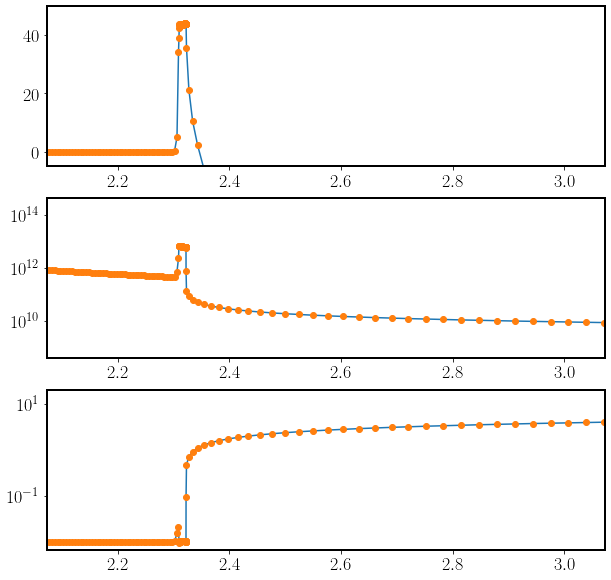

In [9]:
fig, axs = plt.subplots(3,figsize=[10,10])
axs[0].plot(los_x,vel)
axs[0].plot(los_x,vel,'o')
axs[0].set_ylim(-5,50)

axs[1].plot(los_x, n_e)
axs[1].plot(los_x, n_e,'o')
axs[1].set_yscale('log')

axs[2].plot(los_x,t)
axs[2].plot(los_x,t,'o')
axs[2].set_yscale('log')

axs[0].set_xlim(xl,xr)
axs[1].set_xlim(xl,xr)
axs[2].set_xlim(xl,xr)

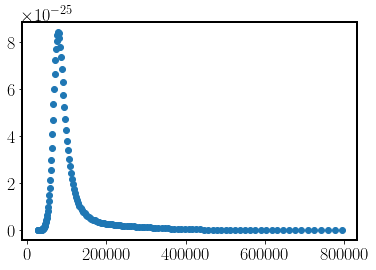

In [10]:
te = 10**log10T
gT = 10**log10G
plt.plot(te,gT,'o')

In [11]:
# nei/eqi arrays at time =time
f_nei=frac.arrs.f_nei[0]
f_nei = f_nei[:,time]
f_eqi=frac.arrs.f_eqi[0]
f_eqi = f_eqi[:,time]

temp_fac = f_nei/f_eqi
np.nan_to_num(temp_fac, copy=False, nan=1); # replace inf values with 1 (due to zeros in eqi)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [12]:
temp0 = tube.tarr.t[0]
i_hot = min(np.where(temp0 > temp0[0])[0])
i_hot,los_x[i_hot]

(455, 3.391472136556945)

In [13]:
#i_min,i_max = i_lim[0]-50,i_lim[0]+50 # define PREFT cells to interpolate
i_min,i_max = i_lim[0]-100,i_lim[0]+100
i_min,i_max

(310, 510)

In [14]:
los_x[i_min],los_x[i_max]

(2.178575714564568, 13.830871234346061)

In [15]:
#i_min,i_max = velf[0]-10,i_hot # fixed interval for averaging in time (for n=200)
interp = 'linear'

#sub arrays
t_s = t[i_min:i_max]
n_s = len(t_s)
los_v_s = los_v[i_min:i_max]
sm_v_s = sm_v[i_min:i_max]
los_x_s = los_x[i_min:i_max]
n_e_s = n_e[i_min:i_max]
b_s = b[i_min:i_max]
dl_e_s = dl_e[i_min:i_max]
f_nei_s = f_nei[i_min:i_max]
f_eqi_s = f_eqi[i_min:i_max]

#EM
A_pixel = 0.029*1e16 # cm^2 -  pixel area: 0.33 x 0.167 arcsec (as seen on sun..)
vol_s = dl_e_s*A_pixel*1e8
EM_s = vol_s*n_e_s**2

# interpolate
N=10*n_s
i_s = np.arange(0,n_s)
ii = np.arange(0,10*(n_s-1))*0.1
i_length = len(ii)

int_x = interp1d(i_s,los_x_s,kind=interp, bounds_error=False)#,fill_value="extrapolate")
int_v = interp1d(i_s,sm_v_s,kind=interp,bounds_error=False)#,fill_value="extrapolate")
int_t = interp1d(i_s,t_s,kind=interp,bounds_error=False)
int_ne = interp1d(i_s,n_e_s,kind=interp,bounds_error=False)
int_b = interp1d(i_s,b_s,kind=interp,bounds_error=False)
int_dl_e = interp1d(i_s,dl_e_s,kind=interp,bounds_error=False)
int_fnei = interp1d(i_s,f_nei_s,kind=interp,bounds_error=False)
int_feqi = interp1d(i_s,f_eqi_s,kind=interp,bounds_error=False)
int_em = interp1d(i_s,EM_s,kind=interp,bounds_error=False)

# new, interpolated arrays from tarr/tube
x = int_x(ii)
v = int_v(ii)
T = int_t(ii)
ne = int_ne(ii)
B = int_b(ii)
Dl = int_dl_e(ii)
nei = int_fnei(ii)
eqi = int_feqi(ii)
em=int_em(ii)

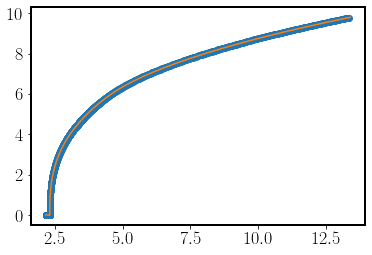

In [16]:
plt.plot(x,T,'o')
plt.plot(los_x_s,t_s)

In [17]:
#inter = interp1d(te,log10G,kind='linear', bounds_error=False, fill_value=-1e6)#fill outide vals with large, small number
inter = interp1d(te,gT,kind='linear', bounds_error=False) #fill outide vals with large, small number
temp2 = 1e6*T
gg = inter(temp2)
gg=np.nan_to_num(gg) # idk why they come out nan, but we do it anyway

(2.0722007967489575, 3.0722007967489575)

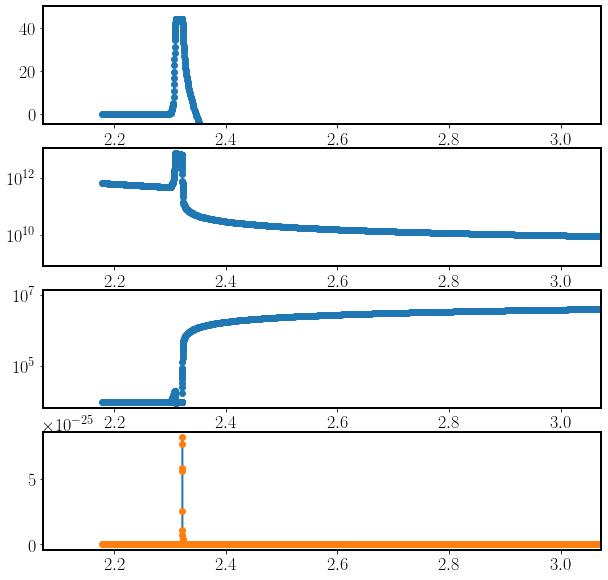

In [18]:
fig, axs = plt.subplots(4,figsize=[10,10])
axs[0].plot(x,v*1e3,'o')
axs[0].set_ylim(-5,50)
axs[1].plot(x, ne,'o')
axs[1].set_yscale('log')
axs[2].plot(x,T*1e6,'o')
axs[2].set_yscale('log')
axs[3].plot(x,gg)
axs[3].plot(x,gg,'o')

axs[0].set_xlim(xl,xr)
axs[1].set_xlim(xl,xr)
axs[2].set_xlim(xl,xr)
axs[3].set_xlim(xl,xr)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


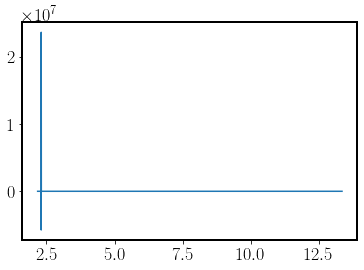

In [19]:
# factor to multiply GofT by to get actual emission given NEI
factor = nei/eqi
np.nan_to_num(factor, copy=False, nan=1); # replace inf values with 1 (due to zeros in eqi)
factor[factor>1e10]=1.0
plt.plot(x,factor)
#plt.plot(los_x,temp_fac)

(2.0722007967489575, 3.0722007967489575)

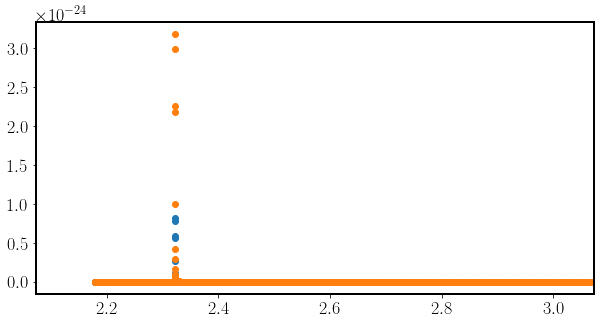

In [20]:
fig, axs = plt.subplots(figsize=[10,5])
axs.plot(x,gg,'o')
axs.plot(x,factor*gg,'o')
axs.set_xlim(xl,xr)

In [21]:
# process to create volume given per flux (per Maxwell)
A_pixel = 0.029*1e16 # cm^2 -  pixel area: 0.33 x 0.167 arcsec (as seen on sun..)
volume = Dl*A_pixel*1e8
EM=volume*(ne**2) #calcualte emission measure EM

(0.0, 0.035)

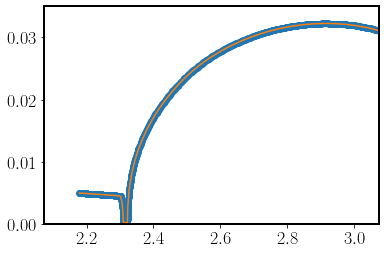

In [22]:
plt.plot(x,Dl,'o')
plt.plot(los_x_s,dl_e_s)
plt.xlim(xl,xr)
plt.ylim(0,0.0009)
plt.ylim(0,0.035)

(2.0722007967489575, 3.0722007967489575)

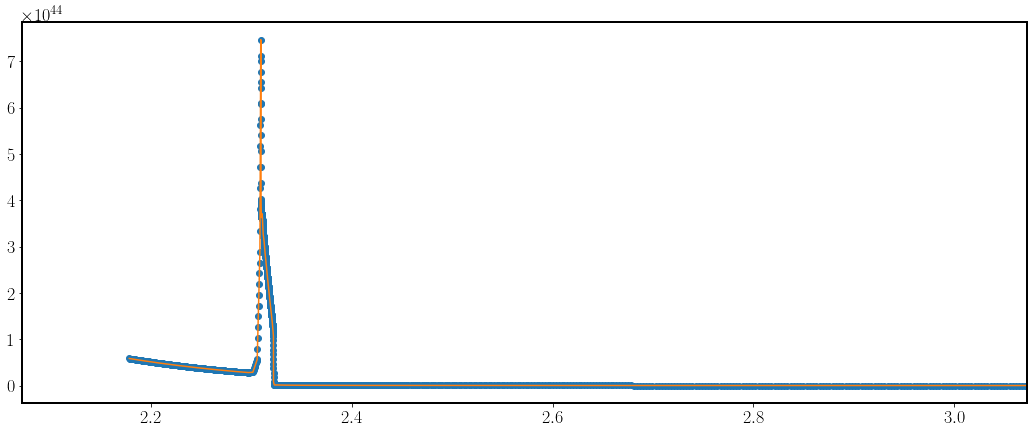

In [23]:
plt.figure(figsize=(18,7))

# t0
n_e0 = tube.tarr.epamu[0]*tube.tarr.rho[0]/1.67e-8 # number density
dl_e0 = tube.tarr.dl_e[0]
vol_0 = dl_e0*A_pixel*1e8

n_e_s0=n_e0[i_min:i_max]
dl_e_s0=dl_e0[i_min:i_max]
vol_s0 = dl_e0*A_pixel*1e8

EMII0=vol_0*n_e0**2


#plt.plot(los_x,EMII0)
plt.plot(x,em,'o')
plt.plot(los_x_s,EM_s)
plt.xlim(xl,xr)
#plt.plot(x,(factor*gg)/np.max(factor*gg))
#plt.ylim(1e40,1e46)

(0.0, 2.0)

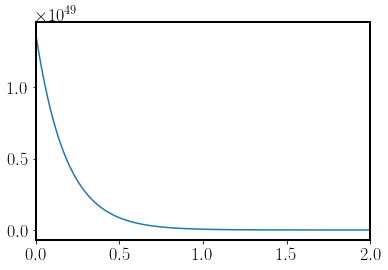

In [24]:
plt.plot(los_x,EMII0)
#plt.semilogy(x,em,'o')
#plt.semilogy(los_x_s,EM_s)
#plt.xlim(xl,xr)
#plt.plot(x,(factor*gg)/np.max(factor*gg))
#plt.ylim(1e40,1e46)
plt.xlim(0,2)

In [25]:
# calculate prefactor to turn intensity into counts
photo_erg = h*c/line_cgs #erg/photon
pixel_size = 12.8e-3 # in ˚A [12.8 m˚A (FUV), 25.6 m˚A (NUV)]
dim = 19e-2
A_iris = 2.2e-4 # effective area FUV
au = 1.49e11
atn = A_iris/au**2
exp_time = 4.0 # double checked, this is more or less right (3.999, or whatever.)
photo_fac = pixel_size*atn*exp_time/photo_erg # converts EM*g/sig (erg/s/sr/˚A) -> photon count

In [26]:
photo_fac

3.580381463610463e-17

In [27]:
# determine line broadening given combination of thermal, non-thermal, and instrumental broadenings
freq = c/line_cgs
v_inst = 3.9 # instrumental broadening (km/s)
sig_inst = v_inst/freq # km
v_nt = 20.0 # non-thermal broadening (km/s) [De Pontieu et al, 2015]
sig_nt = v_nt/freq # km
sig_th = line_cgs*np.sqrt(kb*T/mass)/c # thermal broadening (in cm)
sig_th = sig_th*1e-5 # km
sig = np.sqrt(sig_th**2+sig_nt**2+sig_inst**2) # total broadening km

#sig = np.sqrt(sig_th**2+sig_inst**2)
sig = sig*1e13 # angstrom

sigma=line*np.sqrt(2*k*1e6*T/M)/(c2*1e6)

In [28]:
vcm = v*1e8 # vel in cm (to match c in expotential of intensity)
crv = np.sqrt(2*np.pi)*sig

In [29]:
# create emission array(s) for each fluid element
nn=len(em)
emissNEI = np.empty([nn,len(ll)])
emiss = np.empty([nn,len(ll)])
emission = np.empty([nn,len(ll)])
for i in range(nn):
    emissNEI[i,:] = photo_fac*em[i]*factor[i]*gg[i]/crv[i]*np.exp(-(ll-line-line*(vcm[i]/c))**2/(2*sig[i]**2))
    emiss[i,:] = photo_fac*em[i]*gg[i]/crv[i]*np.exp(-(ll-line-line*(vcm[i]/c))**2/(2*sig[i]**2))
    
    emission[i,:]=em[i]*gg[i]/(np.sqrt(2*np.pi)*sigma[i])*np.exp(-(ll-line-line*v[i]/c2)**2/(2*sigma[i]**2)) # taken from jon, should be old?

# add together all emissions along loop
tot_emissNEI = np.sum(emissNEI,axis=0)
tot_emiss = np.sum(emiss,axis=0)
tot_emission = np.sum(emission,axis=0)

In [30]:
itser = np.where(factor*gg !=0)[0]
itser

array([ 992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001, 1002,
       1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013,
       1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023])

In [31]:
factor[itser]*gg[itser]

array([5.17374685e-29, 3.89652337e-27, 5.12704342e-26, 2.93092764e-25,
       9.97359578e-25, 2.25487433e-24, 3.17711422e-24, 2.98365748e-24,
       2.17945546e-24, 4.24177156e-25, 1.60120761e-25, 9.58118944e-26,
       7.05521137e-26, 5.30488850e-26, 3.73881874e-26, 2.42980824e-26,
       1.47637615e-26, 8.57108626e-27, 7.32616663e-27, 5.08568720e-27,
       3.53410502e-27, 2.45736739e-27, 1.71081652e-27, 1.19653882e-27,
       8.38257155e-28, 5.94261439e-28, 4.31681589e-28, 3.30626752e-28,
       4.18705125e-28, 3.07433998e-28, 2.25474287e-28, 1.65323285e-28])

(2.0722007967489575, 3.0722007967489575)

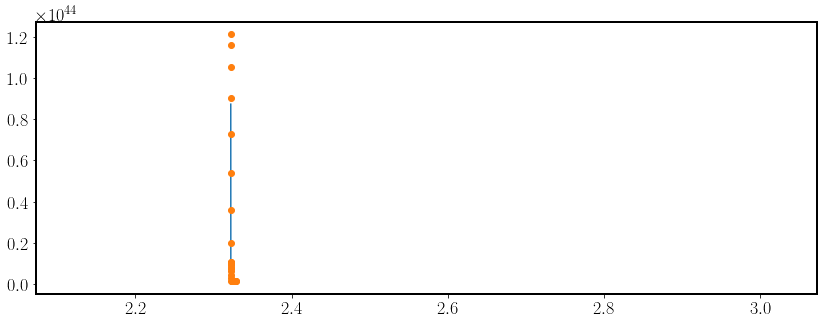

In [32]:
plt.figure(figsize=(14,5))
plt.plot(x[itser],em[itser])
plt.plot(x[itser],EM[itser],'o')
#plt.plot(x,EM/np.max(EM))
#plt.plot(x,(factor*gg)/np.max(factor*gg))
plt.xlim(xl,xr)

In [33]:
i = 995

In [34]:
em[i],gg[i],crv[i],factor[i]

(5.747683427782557e+43,
 7.584551473601811e-26,
 0.2388344400971839,
 3.8643387800823423)

In [35]:
em[i]*factor[i]*gg[i]*photo_fac/crv[i]

2525.4006260223573

In [36]:
#em[itser],volume[itser],ne[itser]

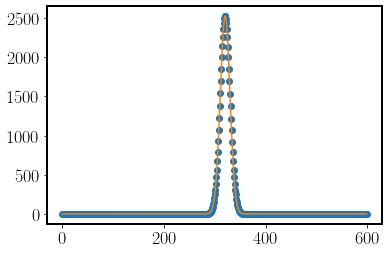

In [37]:
#plt.plot(np.exp(-(ll-line-line*(vcm[i]/c))**2/(2*sig[i]**2)))
plt.plot(photo_fac*em[i]*factor[i]*gg[i]/crv[i]*np.exp(-(ll-line-line*(vcm[i]/c))**2/(2*sig[i]**2)),'o')
plt.plot(emissNEI[i])

(1402.0, 1404.0)

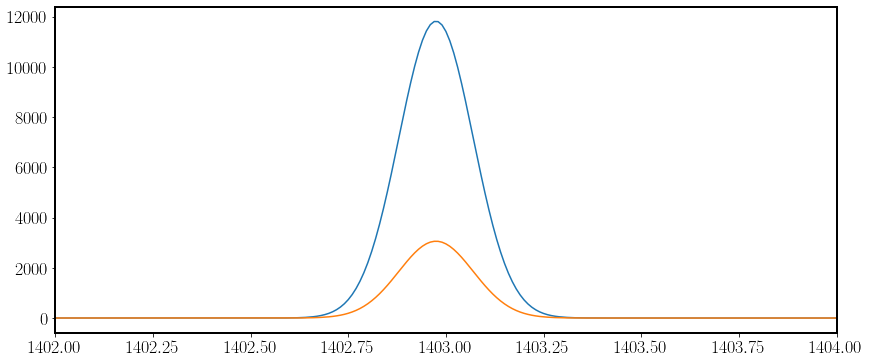

In [38]:
plt.figure(figsize=(14,6))
plt.plot(ll,tot_emissNEI/4.)
plt.plot(ll,tot_emiss/4.)
plt.xlim(1402,1404)

In [41]:
np.max(tot_emissNEI/4.)

11808.500673484452

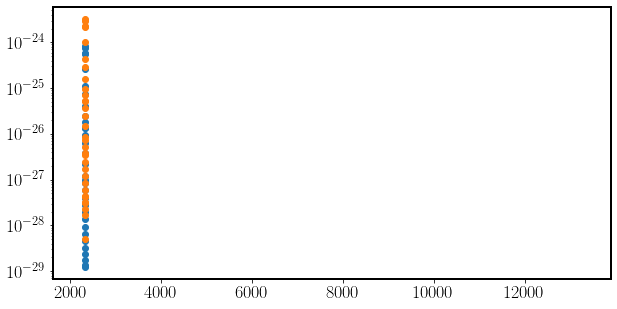

In [39]:
fig, axs = plt.subplots(figsize=[10,5])
axs.semilogy(x*1e3,gg,'o')
axs.semilogy(x*1e3,factor*gg,'o')
#axs.set_xlim(2500,2700)

(0.0, 1.0)

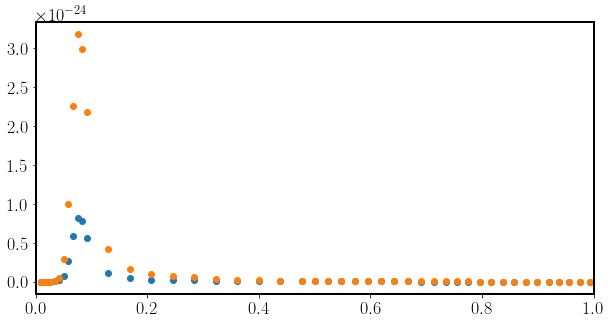

In [40]:
fig, axs = plt.subplots(figsize=[10,5])
axs.plot(T,gg,'o')
axs.plot(T,factor*gg,'o')
axs.set_xlim(0,1)